In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [46]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving occupancy_data.zip to occupancy_data.zip
User uploaded file "occupancy_data.zip" with length 335713 bytes


In [47]:
!unzip ./occupancy_data.zip
!rm ./occupancy_data.zip

Archive:  ./occupancy_data.zip
replace datatest.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.externals.six import StringIO
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [49]:
data1 = pd.read_csv('datatest.txt', sep=",", header=None)
data2 = pd.read_csv('datatraining.txt', sep=",", header=None)
data3 = pd.read_csv('datatest2.txt', sep=",", header=None)
data = pd.concat([data1, data2, data3])
data.columns = ["ID", "Date", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]
data = data.drop(['ID'], axis=1)
data.head()

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [50]:
data.shape

(20560, 7)

In [51]:
data_target = data.Occupancy.values
print('Occupancy == 0: ' + str((len(data_target) - sum(data_target)) / len(data_target)))
print('Occupancy == 1: ' + str(sum(data_target) / len(data_target)))

Occupancy == 0: 0.7689688715953308
Occupancy == 1: 0.23103112840466927


In [52]:
data.isnull().values.any()

False

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 0 to 9751
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [54]:
corr = data.corr()
corr.style.background_gradient()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000


In [55]:
data.Date = data.Date.apply(pd.to_datetime)
data['Hour'] = data.Date.apply(lambda x : x.hour)
data['Minute'] = data.Date.apply(lambda x : x.minute)
data['Second'] = data.Date.apply(lambda x : x.second)
data.head()

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Hour,Minute,Second
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,14,19,0
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,14,19,59
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,14,21,0
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,14,22,0
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,14,23,0


In [0]:
y = data['Occupancy']
X = data.drop(['Occupancy', 'Date', 'HumidityRatio'], axis=1)
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=1)

In [57]:
X_test.head()

,Temperature,Humidity,Light,CO2,Hour,Minute,Second
5640,23.200,28.3900,366.50,629.750000,12,48,0
5641,23.200,28.3900,303.00,631.666667,12,49,0
5642,23.245,28.4450,243.50,633.500000,12,49,59
5643,23.290,28.5000,150.00,633.500000,12,51,0
5644,23.200,28.4725,156.25,633.000000,12,52,0


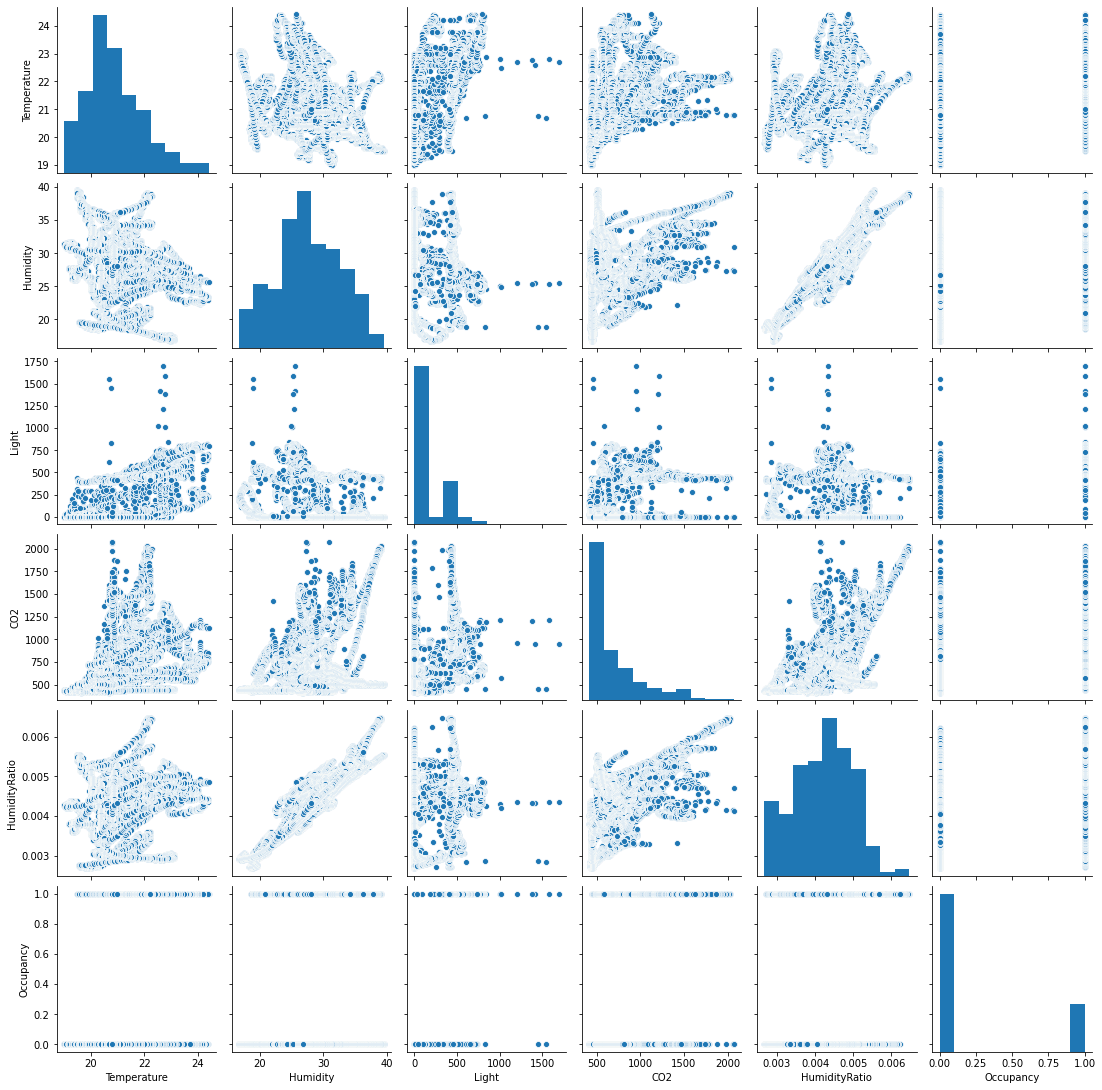

In [58]:
cols = ["Temperature",	"Humidity",	"Light",	"CO2",	"HumidityRatio", "Occupancy"]
sns_plot = sns.pairplot(data[cols])

In [67]:
# Обучение классификатора
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [68]:
predictions = clf.predict(X_test)
metrics.accuracy_score(y_test, predictions)

0.9956225680933852

In [69]:
# Обучение классификатора без ограничений
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
metrics.accuracy_score(y_test, predictions)

0.9900291828793775

In [0]:
# !pip install pydotplus
import pydotplus
from IPython.display import Image

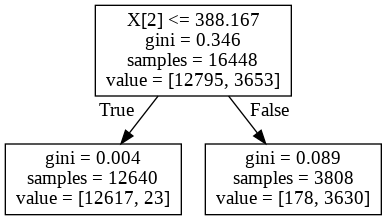

In [0]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
a = (y_test.to_numpy() == predictions)
a = np.where(a == False )[0]
X_false = X_test.iloc[a]
X_false['Occupancy'] = y_test.iloc[a]
X_false

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Temperature,Humidity,Light,CO2,Hour,Minute,Second,Occupancy
6839,20.500000,25.050000,389.00,856.500000,8,47,0,0
6840,20.500000,25.025000,397.00,870.750000,8,48,0,0
6841,20.600000,25.050000,405.00,869.000000,8,49,0,0
6842,20.550000,25.100000,405.00,872.500000,8,50,0,0
6843,20.600000,25.200000,405.00,871.500000,8,51,0,0
7027,21.500000,28.175000,454.00,967.500000,11,55,0,0
7028,21.525000,28.175000,454.00,967.000000,11,55,59,0
7029,21.500000,28.150000,454.00,958.500000,11,57,0,0
7087,21.525000,28.075000,464.00,894.500000,12,55,0,0
7110,21.445000,28.245000,454.00,880.250000,13,18,0,0


In [0]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X_train)
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(scaled)

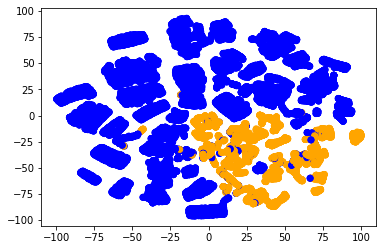

In [0]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=y_train.map({0: 'blue', 1: 'orange'}))

In [0]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data_test)
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(scaled)

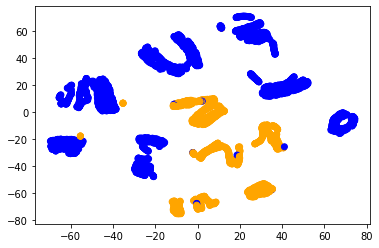

In [0]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=test_labels.map({0: 'blue', 1: 'orange'}))

In [0]:
# def get_meshgrid(data, step=.05, border=.5,):
#     x1_min, x1_max = data.iloc[:, 0].min() - border, data.iloc[:, 0].max() + border
#     x2_min, x2_max = data.iloc[:, 1].min() - border, data.iloc[:, 1].max() + border
#     x3_min, x3_max = data.iloc[:, 2].min() - border, data.iloc[:, 2].max() + border
#     x4_min, x4_max = data.iloc[:, 3].min() - border, data.iloc[:, 3].max() + border
#     x5_min, x5_max = data.iloc[:, 4].min() - border, data.iloc[:, 4].max() + border
#     x6_min, x6_max = data.iloc[:, 5].min() - border, data.iloc[:, 5].max() + border
#     x7_min, x7_max = data.iloc[:, 6].min() - border, data.iloc[:, 6].max() + border
#     x8_min, x8_max = data.iloc[:, 7].min() - border, data.iloc[:, 7].max() + border
#     return np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step), np.arange(x3_min, x3_max, step),
#                        np.arange(x4_min, x4_max, step), np.arange(x5_min, x5_max, step), np.arange(x6_min, x6_max, step),
#                        np.arange(x7_min, x7_max, step), np.arange(x8_min, x8_max, step))


# def get_points_2D(data):
#     scaler = StandardScaler()
#     scaled = scaler.fit_transform(data)
#     tsne = TSNE(random_state=17)
#     tsne_representation = tsne.fit_transform(scaled)
#     return tsne_representation

In [0]:
# colors = ['Blue', 'Yellow']
# light_colors = ['Green', 'Gray']
# def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels, 
#                           colors = colors, light_colors = light_colors):
#     #fit model
#     estimator.fit(train_data, train_labels)
    
#     #set figure size
#     pyplot.figure(figsize = (16, 6))
    
#     #plot decision surface on the train data 
#     pyplot.subplot(1,2,1)
#     xx, yy = get_meshgrid(train_data)
#     mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
#     pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
#     pyplot.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
#     pyplot.title('Train data, accuracy={:.2f}'.format(metrics.accuracy_score(train_labels, estimator.predict(train_data))))
    
#     #plot decision surface on the test data
#     pyplot.subplot(1,2,2)
#     pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
#     pyplot.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
#     pyplot.title('Test data, accuracy={:.2f}'.format(metrics.accuracy_score(test_labels, estimator.predict(test_data))))

In [0]:
data.query('Light > 0 & Occupancy == 1').shape[0]

4749

In [0]:
data.query('Occupancy == 1').shape[0]

4750

In [0]:
data.query('Light > 0 & Occupancy == 1')

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Hour,Minute,Second
0,2015-02-02 14:19:00,23.7000,26.2720,585.200000,749.200000,0.004764,1,14,19,0
1,2015-02-02 14:19:59,23.7180,26.2900,578.400000,760.400000,0.004773,1,14,19,59
2,2015-02-02 14:21:00,23.7300,26.2300,572.666667,769.666667,0.004765,1,14,21,0
3,2015-02-02 14:22:00,23.7225,26.1250,493.750000,774.750000,0.004744,1,14,22,0
4,2015-02-02 14:23:00,23.7540,26.2000,488.600000,779.000000,0.004767,1,14,23,0
...,...,...,...,...,...,...,...,...,...,...
9747,2015-02-18 09:15:00,20.8150,27.7175,429.750000,1505.250000,0.004213,1,9,15,0
9748,2015-02-18 09:16:00,20.8650,27.7450,423.500000,1514.500000,0.004230,1,9,16,0
9749,2015-02-18 09:16:59,20.8900,27.7450,423.500000,1521.500000,0.004237,1,9,16,59
9750,2015-02-18 09:17:59,20.8900,28.0225,418.750000,1632.000000,0.004279,1,9,17,59
